---
# Apples to Apples
### John Thurman
---

## Table of Contents
* #### [Introduction](#Introduction)
    * [Define functions](#DefineFunctions)
    * [Loading Data](#LoadingData)
    * [Data exploration](#DataExploration)
* #### [Modelling fruit 360 data](#ModellingSection1)
    * [Random Forest Benchmark](#Benchmark)
    * [2 Convolution CNN](#Model1)
    * [4 Convolution CNN](#Model2)
    * [Transfer learning](#Model3)
    * [General Comments](#Comments1)
* #### [Modelling flickr data](#ModellingSection2)
    * [4 Convolution CNN](#Model4)
    * [Transfer learning](#Model5)
    * [General Comments](#Comments2)
* #### [Reduced fruit subset](#ModellingSection3)
    * [4 Convolutions CNN](#Model6)
    * [Transfer learning](#Model7)
    * [Hyper-parameter tuning](#Hyperparam)
    * [General Comments](#Comments3)
* #### [Other](#Other)
    * [Image Augmentation](#ImageAugmentation)





Load the appropriate libraries

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import pickle
import os
import glob

from keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy, sparse_top_k_categorical_accuracy
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

print('Tensorflow version \t:', tf.__version__)
print(tf.test.is_gpu_available(), tf.test.is_built_with_cuda(), tf.test.gpu_device_name())

Tensorflow version 	: 1.10.0
True True /device:GPU:0


<a id="Introduction"> </a>
# Introduction

The objective of this project is to determine whether image classification techniques can be used to distinguish between different types of fruit. The project looks at 4 general types of model:
* Random Forest Classifier (Used as a benchmark)
* A Convoltional Neural network (CNN) with 2 convolutional layers
* CNN with 4 convolutional layers
* CNN using transfer learning from a mobilenet (V2) model that has been trained on the Imagenet dataset.

The data used for this project has come from two sources:
* 'fruit-360' dataset produced by Horea Muresan, Mihai Oltean, and available at kaggle 
<a href='https://www.kaggle.com/moltean/fruits'> here </a> 
* A dataset that was compiled using the Flickr API with additional manual cleaning. A separate jupyter notebook has been included detailing the steps taken to collect this data

This project has been split into two sections, seperated by the two of data sources

<a id="DefineFunctions"></a>
# Defining useful functions 

These functions are used throughout the document in the analysis

In [2]:
#Metric for defining success. In addition to accr
def custom_accuracy(ytrue, ypred):
    '''
    An accuracy where we determine whether we manage to guess the product within the top 4 tries.
    '''
    return sparse_top_k_categorical_accuracy(ytrue, ypred, k=4)

# functions for plotting learning
def plt_history(history):
    '''
    For use with a keras based model.
    This model will plot the loss, accuracy and 'top4 accuracy' per epoch.
    '''
    
    plt.figure(figsize=[20,6]);
    for counter, metric in enumerate(['loss', 'acc', 'custom_accuracy']):
    
        val_metric = 'val_'+metric
        plt.subplot(1,3,counter+1)
        plt.plot(history.history[metric],'r',linewidth=3.0);
        plt.plot(history.history[val_metric],'b',linewidth=3.0);
        plt.legend(['Training '+ metric, 'Validation '+metric,],fontsize=18);
        plt.xlabel('Epochs ',fontsize=16);
        plt.ylabel(metric ,fontsize=16);
        plt.title(metric +' Curves',fontsize=16);   

def convert_to_supergroup(x):
    '''
    The fruit-360 data comes in 95 different varieties typically sub-species (e.g. Braeburn). The Flicker data comes
    just over 50 varieties typically super species (e.g. Apple). This converst sub-species to super specie.
    '''
    
    df_supergroup = pd.read_csv('./data/FruitCategories.csv')
    df_x = pd.DataFrame(x, columns=['SubCategory'])
    return list((pd.merge(df_x, df_supergroup, on='SubCategory', how='left').loc[:,'Category']).values)

def plot_first_group(data, prediction_labels, truth_labels, number=15):
    '''
    This draws the first n
    '''
    plt.figure(figsize=(20,10))
    for count, photo in enumerate(prediction_labels[:number]):
        rows = (number-1)//5+1
        plt.subplot(rows,5, count+1)
        b,g,r = cv2.split(data[count,:,:,:])       
        rgb_img = cv2.merge([r,g,b]) 
        plt.imshow(rgb_img)
        plt.title(photo+'({}) ' .format(truth_labels[count]))
 
def load_data(directory, maxData=None, randomState=1):
    '''
    Loads the different data sets from file. Smaller (random) subsets can be taken for experimenting by using the MaxData and 
    random state parameters
    '''
    #Get list of all images in directory
    imagePaths = glob.glob(directory+'/*/*.jpg', recursive=True)
    
    if maxData is not None:
        np.random.set_state=randomState
        imagePaths = np.random.choice(imagePaths,size=maxData)
          
    X =[]
    y =[]
    for path in imagePaths:
        label = path.split("\\")[-2]
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        X.append(image)
        y.append(label)
        
    return np.array(X), np.array(y)

<a id='LoadingData'></a>
# Load data

#### Fruit 360 data set

In [3]:
# Load training set
X,y = load_data('./data/fruits/fruits-360/Training',maxData=20000)

#Preprocess the data using a label encoder and diving by 255
label_encoder = LabelEncoder()
label_encoder.fit(y)
X = X/255
y = label_encoder.transform(y)

# Create train, validation split
X_train, X_val, y_train, y_val = train_test_split(X, y)

# Save the label encoder to file
fileObject = open('labelEncoding.pkl','wb')
pickle.dump(label_encoder,fileObject)
fileObject.close()

In [4]:
# test data is a hold out set specificly identified in the data set. Load this data and preprocess
X_test,y_test = load_data('./data/fruits/fruits-360/Test', maxData=10000)
X_test = X_test/255
y_test = label_encoder.transform(y_test)

In [10]:
INPUTSHAPE = (100,100,3)
OUTPUTSHAPE = len(np.unique(y))
del X, y #To free up space as otherwise there is a duplication of this data

#### Flickr data

In [3]:
# load data
X_flickr, y_flickr = load_data('./data/flickr')
X_flickr = X_flickr/255

#Create the reduced dataset:
fruitsubset = ['Strawberry', 'Apple', 'Lemon', 'Orange', 'Mango', 'Banana', 'Grape', 'Passion Fruit', 'Peach']
infruitsubset = np.in1d(y_flickr, fruitsubset)
X_flickr_subset = X_flickr[infruitsubset]
y_flickr_subset = y_flickr[infruitsubset]

#need a new encoder as the data has different labels than the fruit 360 dataset
label_encoder_flickr = LabelEncoder()

#transformation on data
y_flickr = label_encoder_flickr.fit_transform(y_flickr)
X_flickr_train, X_flickr_test, y_flickr_train, y_flickr_test = train_test_split(X_flickr, y_flickr,  test_size=300)
X_flickr_train, X_flickr_val, y_flickr_train, y_flickr_val = train_test_split(X_flickr_train, y_flickr_train,  test_size=0.2, train_size=0.8)

# Save the label encoder to use in predictions in a web app
fileObject = open('labelEncodingFlickr.pkl','wb')
pickle.dump(label_encoder_flickr,fileObject)
fileObject.close()

#Output shape for the modelling params
OUTPUTSHAPEFLICKR = len(np.unique(y_flickr))

In [4]:
#need a new encoder as the data has different labels than the fruit 360 dataset (and smaller than the other flickr encoding)
label_encoder_flickr_subset = LabelEncoder()

#transformation on data
y_flickr_subset = label_encoder_flickr_subset.fit_transform(y_flickr_subset)
X_flickr_subset_train, X_flickr_subset_test, y_flickr_subset_train, y_flickr_subset_test = train_test_split(X_flickr_subset, y_flickr_subset,  test_size=300)
X_flickr_subset_train, X_flickr_subset_val, y_flickr_subset_train, y_flickr_subset_val = train_test_split(X_flickr_subset_train, y_flickr_subset_train,  test_size=0.2, train_size=0.8)

# Save the label encoder to use in predictions in a web app
fileObject = open('labelEncodingFlickrSubset.pkl','wb')
pickle.dump(label_encoder_flickr_subset,fileObject)
fileObject.close()

#Output shape for the modelling params
OUTPUTSHAPEFLICKRSUBSET = len(np.unique(y_flickr_subset))

#To free up space as otherwise there is a duplication of this data
del X_flickr, y_flickr

# Data Exploration <a id='DataExploration'></a>

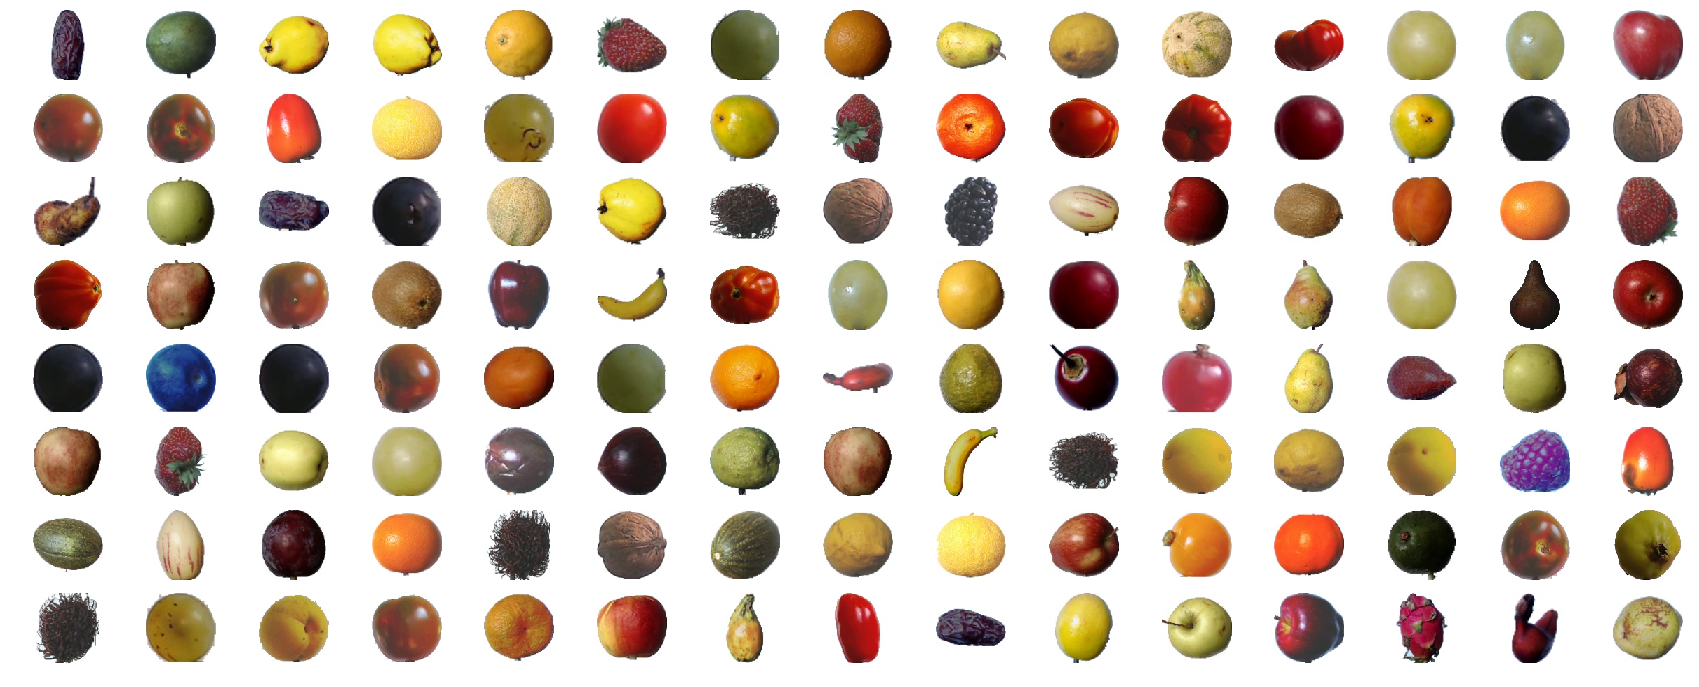

In [9]:
plt.figure(figsize=(30,12))
for i in range(120):
    plt.subplot(8,15,i+1)
    plt.imshow(X_train[i,:,:,:])
    #plt.title(y[i], size = 10)
    plt.axis('off')

<a id=ModellingSection1></a>
<a id=Benchmark></a>
# Modelling using fruit 360 training data
## Random Forest Benchmark

Completed for Flickr data and the fruit-360 dataset

In [10]:
#Flatten the data
# Note that the data in the fruit 360 dataset is made up of 60000*30000*8(byte) floats -> This is 13GB of RAM needed to store. 
# Making a copy can be quite painful! The 
X_train_flat = X_train.reshape((len(X_train),30000))
X_test_flat = X_test.reshape((len(X_test), 30000))

X_flickr_train_flat = X_flickr_train.reshape((len(X_flickr_train),30000))
X_flickr_val_flat = X_flickr_val.reshape((len(X_flickr_val), 30000))

In [11]:
clf = RandomForestClassifier(n_estimators=10)

clf.fit(X_train_flat, y_train)
print('Training accuracy \t: %.3f' % clf.score(X_train_flat, y_train))
print('Test accuracy \t\t: %.3f' % clf.score(X_test_flat, y_test))


Training accuracy 	: 1.000
Test accuracy 		: 0.915


In [12]:
clf = RandomForestClassifier(n_estimators=10)

clf.fit(X_flickr_train_flat, y_flickr_train)
print('Training accuracy \t: %.3f' % clf.score(X_flickr_train_flat, y_flickr_train))
print('Test accuracy \t\t: %.3f'  % clf.score(X_flickr_val_flat, y_flickr_val))

Training accuracy 	: 0.995
Test accuracy 		: 0.234


In [25]:
del X_train_flat, X_test_flat, X_flickr_train_flat #create space

NameError: name 'X_train_flat' is not defined

<a id='Model1'> </a>
### Model 1 - Two layer convolutional neural network

In [13]:
#Define a model:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=INPUTSHAPE))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(264, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(OUTPUTSHAPE, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', custom_accuracy])  

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 264)               8651016   
_________________________________________________________________
dropout_1 (Dropout)          (None, 264)               0         
__________

In [14]:
# training model with early stopping
cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=5, verbose=0, mode='auto')
         
history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    callbacks = [cp_earlystop],
                    epochs=100, verbose=0)

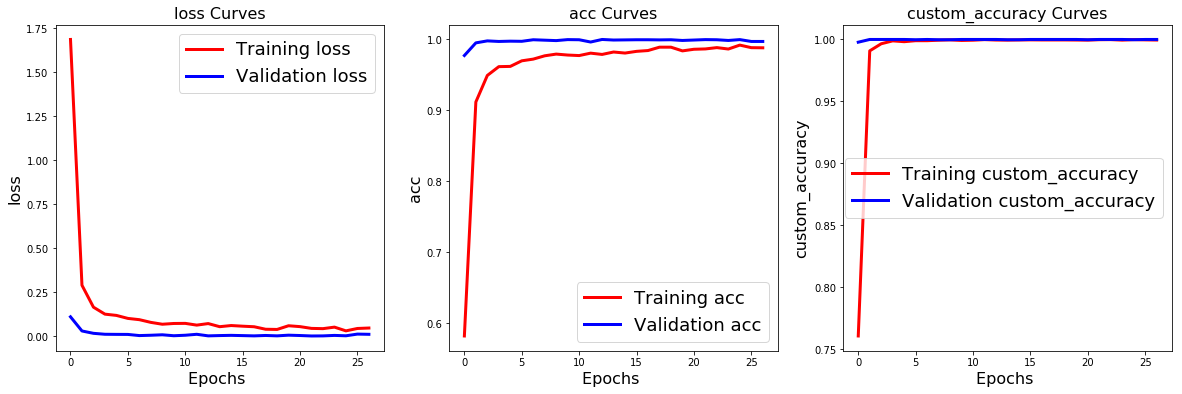

In [15]:
#plot the training history
plt_history(history)

In [16]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',model.evaluate(X_test, y_test, verbose=0)[1])

print('The accuracy of the model on a set of real life images:')

# Note that the real life images have a different categories. Only the superclass (e.g. Apple) and not 
# the subclass (e.g. Braeburn) has been included
labels_predict = label_encoder.inverse_transform(model.predict_classes(X_flickr_test))
labels_predict_flickr = list(convert_to_supergroup(labels_predict))
print('Accuracy \t: %.3f' % accuracy_score(labels_predict_flickr, label_encoder_flickr.inverse_transform(y_flickr_test)))

The accuracy of the model on a test set:
Accuracy 	: 0.9573
The accuracy of the model on a set of real life images:
Accuracy 	: 0.050


In [17]:
#save the model
path_weights = './saved_models/model1/weights.h5'
path_model = './saved_models/model1/model.json'

#Save Model
model_json = model.to_json()
with open(path_model, "w") as json_file:
    json_file.write(model_json)
model.save_weights(path_weights)

In [26]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

This model made an improvement on the benchmark random forest classifier
<a id='Model2'></a>

## Model 2 - 4 layer convolutional neural network

In [27]:
class CNN4LayerModel():
    
    def __init__(self, outputshape, 
                 conv1filter = 32, conv1size=3, stride1=2,
                 conv2filter=32, conv2size=3,
                 conv3filter=64, conv3size=3,
                 conv4filter=64, conv4size=3, 
                 denseNodes1=128, dropout1=0.5):
        #Save params for reporting
        self.saved_arguments = locals()
    
        #Create Model
        self.model = Sequential()
        self.model.add(Conv2D(conv1filter,(conv1size,conv1size),padding='same',strides=(stride1,stride1),activation='relu'))
        self.model.add(Conv2D(conv2filter, (conv2size, conv2size),padding ='same',activation='relu'))
        self.model.add(MaxPooling2D(2,2))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(conv3filter, (conv3size, conv3size),padding ='same',activation='relu'))
        self.model.add(Conv2D(conv4filter, (conv4size, conv4size),padding ='same',activation='relu'))
        self.model.add(MaxPooling2D(2,2))
        self.model.add(BatchNormalization())
        self.model.add(Flatten())
        self.model.add(Dense(denseNodes1, activation='relu'))
        self.model.add(Dropout(dropout1))
        self.model.add(BatchNormalization())
        self.model.add(Dense(outputshape, activation='softmax'))
    
    def compile_model(self, optimizer='adam'):
        #compile model
        self.model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy', custom_accuracy]) 
        
    def summarise(self):
        self.model.summary()

    def get_results(self, X_train, y_train, X_val, y_val, X_test, y_test, verbose=0):
        #Run model
        cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=10, verbose=0, mode='auto')
        
        self.history = self.model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    callbacks = [cp_earlystop],
                    epochs=100, verbose=verbose)
        
        #Get scores            
        scores = self.model.evaluate(X_test, y_test, verbose=0)
        Accuracyscore = scores[1]
        K_Accuracyscore = scores[2]
                    
        return {**self.saved_arguments, 
                'Training Accuracy' : self.history.history['acc'][-1],
                'Training Top-4 Accuracy': self.history.history['custom_accuracy'][-1],
                'Validation Accuracy':self.history.history['val_acc'][-1],
                'Validation Top-4 Accuracy': self.history.history['val_custom_accuracy'][-1],
                'Test Accuracy': scores[1],
                'Test Top-4 Accuracy': scores[2]}
    
    def plot_results(self):
        plt_history(self.history)
                                    

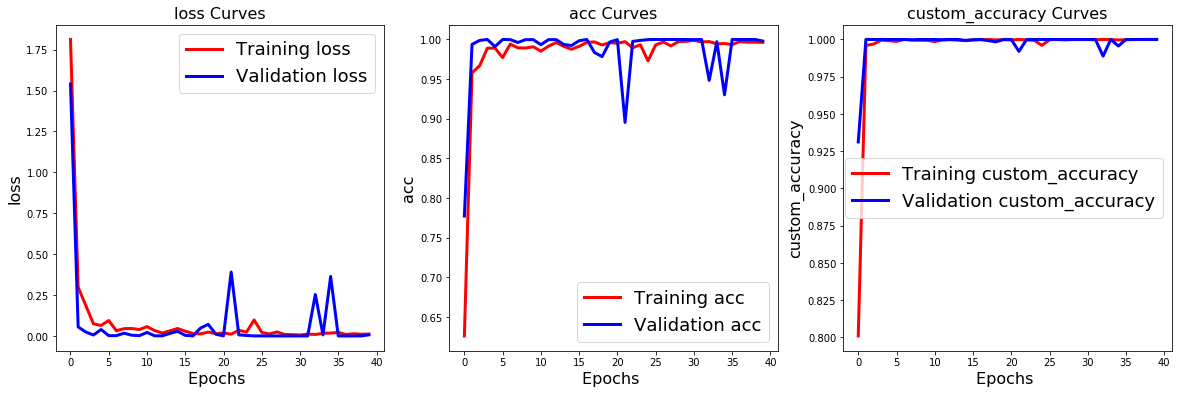

In [19]:
model2 = CNN4LayerModel(OUTPUTSHAPE)
model2.compile_model()
results = model2.get_results(X_train, y_train,X_val, y_val, X_test, y_test, verbose=0)
model2.plot_results()

In [20]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))

print('The accuracy of the model on a set of real life images:')

# Note that the real life images have a different categories. Only the superclass (e.g. Apple vs. Braeburn) has been included
labels_predict = label_encoder.inverse_transform(model2.model.predict_classes(X_flickr_test))
labels_predict_flickr = list(convert_to_supergroup(labels_predict))
print('Accuracy \t: %.3f' % accuracy_score(labels_predict_flickr, label_encoder_flickr.inverse_transform(y_flickr_test)))

The accuracy of the model on a test set:
Accuracy 	: 0.971
The accuracy of the model on a set of real life images:
Accuracy 	: 0.050


In [21]:
path_weights = './saved_models/model2/weights.h5'
path_model = './saved_models/model2/model.json'

#Save Model
model_json = model2.model.to_json()
with open(path_model, "w") as json_file:
    json_file.write(model_json)
model2.model.save_weights(path_weights)

In [ ]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

<a id='Model3'></a>
# Model 3 - Transfer learning model

In [5]:
class TransferLearningModel():
    
    def __init__(self, outputshape, dropout1=0.5, dropout2=0.5, denseNodes=264, \
                 featureVectorString='https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/2'):
        #Save params for reporting
        self.saved_arguments = locals()
    
        #Get feature vector
        module = hub.Module(featureVectorString, trainable=False, name='featureVector')
        height, width = hub.get_expected_image_size(module)

        resize_layer = Lambda(lambda x: tf.image.resize_images(x, (height,width)), input_shape = INPUTSHAPE)
        FeatureVector128 = Lambda(module, input_shape = [height,width,3])
        
        #Create Model
        self.model = Sequential()
        self.model.add(resize_layer)
        self.model.add(FeatureVector128)
        self.model.add(Dropout(dropout1))
        self.model.add(Dense(denseNodes, activation='relu'))
        self.model.add(Dropout(dropout2))
        self.model.add(Dense(outputshape, activation='softmax'))
    
    def compile_model(self, optimizer='adam'):
        #compile model
        self.model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy', custom_accuracy])  

    def get_results(self, X_train, y_train, X_val, y_val, X_test, y_test, verbose=0):
        #Run model
        cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=5, verbose=0, mode='auto')
        
        self.history = self.model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    callbacks = [cp_earlystop],
                    epochs=100, verbose=verbose)
        
        #Get scores            
        scores = self.model.evaluate(X_test, y_test, verbose=0)
        Accuracyscore = scores[1]
        K_Accuracyscore = scores[2]
                    
        return {**self.saved_arguments, 
                'Training Accuracy' : self.history.history['acc'][-1],
                'Training Top-4 Accuracy': self.history.history['custom_accuracy'][-1],
                'Validation Accuracy':self.history.history['val_acc'][-1],
                'Validation Top-4 Accuracy': self.history.history['val_custom_accuracy'][-1],
                'Test Accuracy': scores[1],
                'Test Top-4 Accuracy': scores[2]}
    
    def plot_results(self):
        plt_history(self.history)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 14:40:38.373903  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


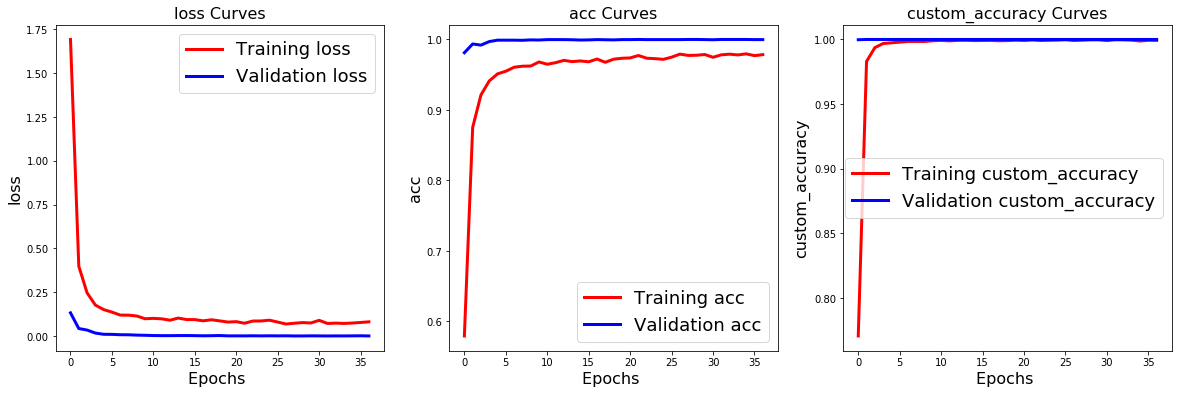

In [29]:
model3 = TransferLearningModel(OUTPUTSHAPE)
model3.compile_model()
#model3.summarise()
results = model3.get_results(X_train, y_train,X_val, y_val, X_test, y_test, verbose=0)
model3.plot_results()

In [30]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))

print('The accuracy of the model on a set of real life images:')

# Note that the real life images have a different categories. Only the superclass (e.g. Apple vs. Braeburn) has been included
labels_predict = label_encoder.inverse_transform(model3.model.predict_classes(X_flickr_test))
labels_predict_flickr = list(convert_to_supergroup(labels_predict))
print('Accuracy \t: %.3f' % accuracy_score(labels_predict_flickr, label_encoder_flickr.inverse_transform(y_flickr_test)))

The accuracy of the model on a test set:
Accuracy 	: 0.979
The accuracy of the model on a set of real life images:
Accuracy 	: 0.177


In [31]:
path_weights = './saved_models/model3/weights.h5'
path_model = './saved_models/model3/model.json'

#Note that the model does not save using the path save_model method. 
model3.model.save_weights(path_weights)

In [32]:
del X_train,y_train, X_val, y_val, X_test, y_test
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint


<a id=Comments1></a>
## Commentary

To be completed


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = label_encoder.inverse_transform(y_test)
y_predict = label_encoder.inverse_transform(model3.predict_classes(X_flickr_))

plt.figure(figsize=(16,8))
sns.heatmap(-np.log(confusion_matrix(y_true, y_predict)));

<a id='ModellingSection2'></a> <a id="Model4"></a>
# Modelling using flickr training data
## Model 4 - 4 layer convolutional neural network


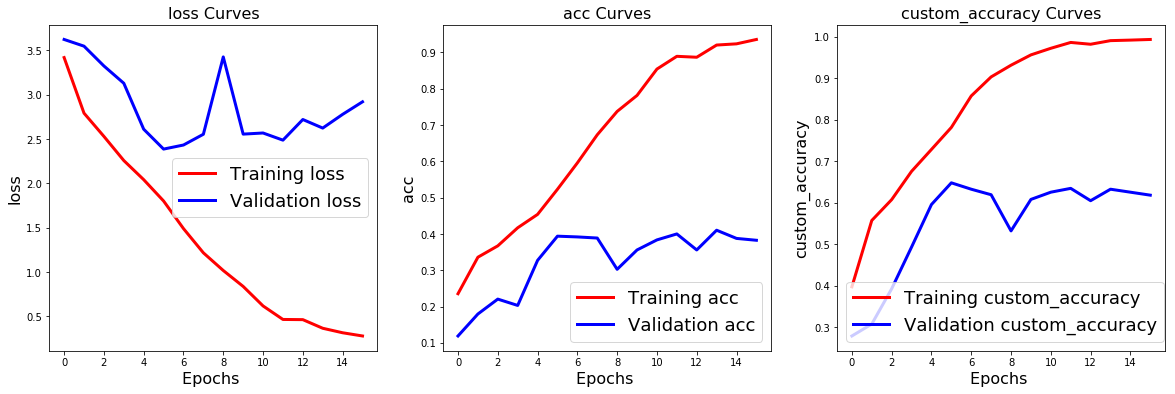

In [33]:
model4 = CNN4LayerModel(OUTPUTSHAPEFLICKR)
model4.compile_model()
#model4.summarise()
results = model4.get_results(X_flickr_train, y_flickr_train,X_flickr_val, y_flickr_val, X_flickr_test, y_flickr_test, verbose=0)
model4.plot_results()

In [34]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))

The accuracy of the model on a test set:
Accuracy 	: 0.42


In [35]:
path_weights = './saved_models/model4/weights.h5'
path_model = './saved_models/model4/model.json'

#Save Model
model_json = model4.model.to_json()
with open(path_model, "w") as json_file:
    json_file.write(model_json)
model4.model.save_weights(path_weights)

In [36]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

<a id="Model5"></a>
## Model 5 - Transfer learning using Mobilenet V2

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:20:14.295368  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


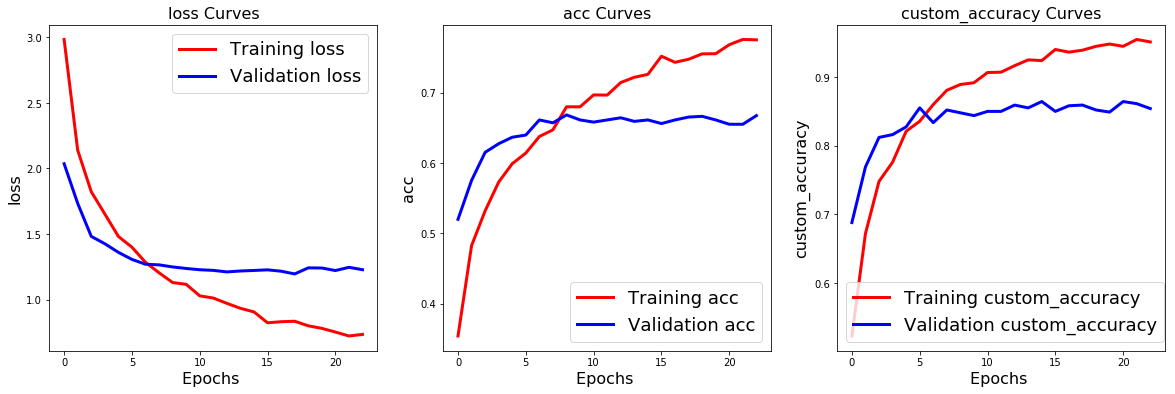

In [37]:
model5 = TransferLearningModel(OUTPUTSHAPEFLICKR)
model5.compile_model()
#model5.summarise()
results = model5.get_results(X_flickr_train, y_flickr_train,
                             X_flickr_val, y_flickr_val, 
                             X_flickr_test, y_flickr_test, verbose=0)
model5.plot_results()

In [38]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))

The accuracy of the model on a test set:
Accuracy 	: 0.68


In [39]:
path_weights = './saved_models/model5/weights.h5'
path_model = './saved_models/model5/model.json'

#Note that the model does not save using the path save_model method. 
model5.model.save_weights(path_weights)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score

y_true = y_flickr_val
y_predict = model5.model.predict_classes(X_flickr_val)

plt.figure(figsize=(16,8))
sns.heatmap(-np.log(confusion_matrix(y_true, y_predict)));

In [40]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

# Training a model on a reduced fruit subset <a id='ModellingSection3'></a>
## Model 6 - 4 Convolutional layers CNN <a id='Model6'></a>

Train on 2281 samples, validate on 571 samples
Epoch 1/100
2281/2281 [==============================] - 5s 2ms/step - loss: 1.7472 - acc: 0.4559 - custom_accuracy: 0.7883 - val_loss: 2.1319 - val_acc: 0.1769 - val_custom_accuracy: 0.6025
Epoch 2/100
2281/2281 [==============================] - 2s 1ms/step - loss: 1.3372 - acc: 0.5704 - custom_accuracy: 0.8917 - val_loss: 2.3321 - val_acc: 0.1821 - val_custom_accuracy: 0.5236
Epoch 3/100
2281/2281 [==============================] - 2s 1ms/step - loss: 1.1776 - acc: 0.5932 - custom_accuracy: 0.9277 - val_loss: 2.3777 - val_acc: 0.1751 - val_custom_accuracy: 0.4834
Epoch 4/100
2281/2281 [==============================] - 2s 1ms/step - loss: 1.0333 - acc: 0.6405 - custom_accuracy: 0.9430 - val_loss: 2.1182 - val_acc: 0.2347 - val_custom_accuracy: 0.6357
Epoch 5/100
2281/2281 [==============================] - 2s 1ms/step - loss: 0.9036 - acc: 0.6830 - custom_accuracy: 0.9645 - val_loss: 1.8239 - val_acc: 0.3170 - val_custom_accuracy: 0.795

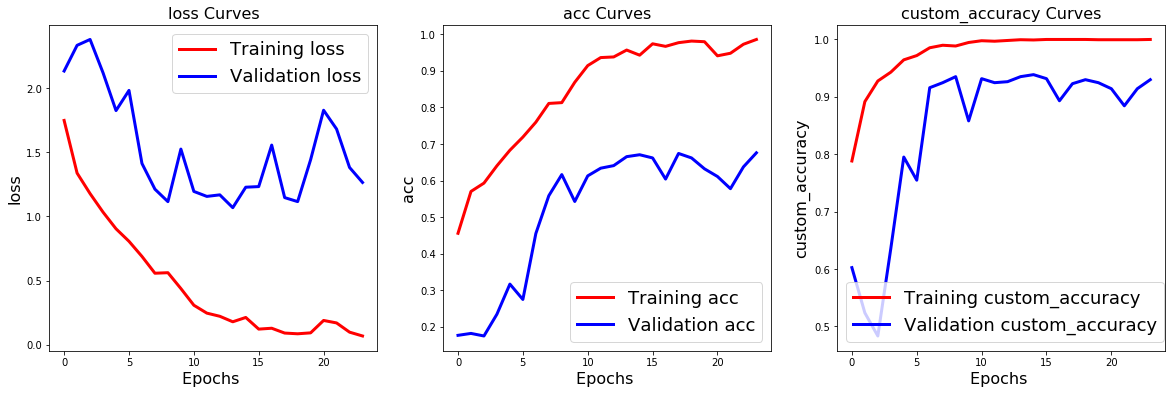

In [41]:
model6 = CNN4LayerModel(OUTPUTSHAPEFLICKRSUBSET)
model6.compile_model()
results = model6.get_results(X_flickr_subset_train, y_flickr_subset_train,
                             X_flickr_subset_val, y_flickr_subset_val, 
                             X_flickr_subset_test, y_flickr_subset_test, verbose=1)
model6.plot_results()

In [42]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))

The accuracy of the model on a test set:
Accuracy 	: 0.673


In [43]:
path_weights = './saved_models/model6/weights.h5'
path_model = './saved_models/model6/model.json'

#Save Model
model_json = model6.model.to_json()
with open(path_model, "w") as json_file:
    json_file.write(model_json)
model6.model.save_weights(path_weights)

In [44]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

# Model 7 - Transfer learning using the Mobilenet V2 model <a id='Model7'></a>

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:24:11.027976  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Train on 2281 samples, validate on 571 samples
Epoch 1/100
2281/2281 [==============================] - 7s 3ms/step - loss: 1.3386 - acc: 0.5914 - custom_accuracy: 0.8645 - val_loss: 0.5510 - val_acc: 0.8266 - val_custom_accuracy: 0.9790
Epoch 2/100
2281/2281 [==============================] - 4s 2ms/step - loss: 0.6911 - acc: 0.7694 - custom_accuracy: 0.9671 - val_loss: 0.4547 - val_acc: 0.8424 - val_custom_accuracy: 0.9860
Epoch 3/100
2281/2281 [==============================] - 4s 2ms/step - loss: 0.5957 - acc: 0.8110 - custom_accuracy: 0.9741 - val_loss: 0.4235 - val_acc: 0.8616 - val_custom_accuracy: 0.9930
Epoch 4/100
2281/2281 [==============================] - 4s 2ms/step - loss: 0.5092 - acc: 0.8238 - custom_accuracy: 0.9816 - val_loss: 0.3777 - val_acc: 0.8774 - val_custom_accuracy: 0.9895
Epoch 5/100
2281/2281 [==============================] - 4s 2ms/step - loss: 0.4656 - acc: 0.8417 - custom_accuracy: 0.9864 - val_loss: 0.3785 - val_acc: 0.8739 - val_custom_accuracy: 0.989

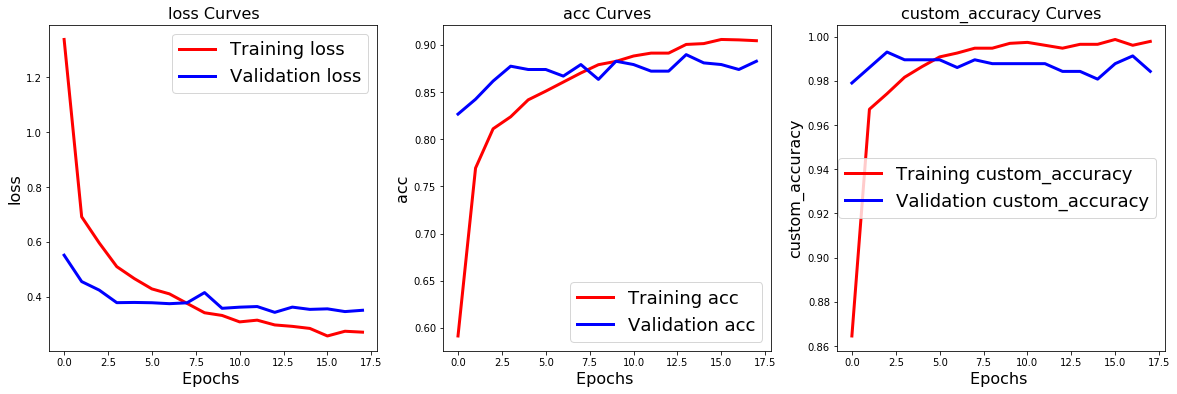

In [45]:
model7 = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET)
model7.compile_model()
#model7.summarise()
results = model7.get_results(X_flickr_subset_train, y_flickr_subset_train,
                             X_flickr_subset_val, y_flickr_subset_val, 
                             X_flickr_subset_test, y_flickr_subset_test, verbose=0)
model7.plot_results()

In [46]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',round(results['Test Accuracy'],3))

The accuracy of the model on a test set:
Accuracy 	: 0.857


In [47]:
path_weights = './saved_models/model7/weights.h5'
model7.model.save_weights(path_weights)

In [48]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

# Hyper parameter tuning <a id='Hyperparam'></a>

### Grid search a number of alternative parameters for the model

In [ ]:
#Number of repeats for averaging:
repeats=1 

featureModels = [#"https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2",
                "https://tfhub.dev/google/imagenet/mobilenet_v2_050_128/feature_vector/2",
                "https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2",
                "https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/2"]

results = []
counter=0
for dropout1 in [0.1,0.2,0.3]:
    for dropout2 in [0.1, 0.2,0.3]:
        for denseNodes in [128,256,512]:
            for featureVectorString in featureModels:
                for repeat in range(repeats):
                    counter +=1
                    model = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET, 
                                                  dropout1, dropout2, 
                                                  denseNodes, featureVectorString)
                    model.compile_model()
                    model_results = model.get_results(X_flickr_subset_train, y_flickr_subset_train,
                                                 X_flickr_subset_val, y_flickr_subset_val, 
                                                 X_flickr_subset_test, y_flickr_subset_test, verbose=0)
                    print('Model : {}' .format(counter), 'Test Accuracy : {} ' .format(100*round(model_results['Test Accuracy'],3)))
                    results.append(model_results)
                    K.clear_session() #reduces the memory footprint
                    tf.reset_default_graph() #reduces the memory footprint
    
results = pd.DataFrame(results)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:40:50.075163  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 1 Test Accuracy : 83.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:41:21.112604  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 2 Test Accuracy : 83.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:41:51.855352  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 3 Test Accuracy : 84.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:42:34.361629  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 4 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:43:09.174489  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 5 Test Accuracy : 86.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:43:46.313127  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 6 Test Accuracy : 84.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:44:31.696706  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 7 Test Accuracy : 84.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:45:07.963675  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 8 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:45:55.601224  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 9 Test Accuracy : 83.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:46:50.178206  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 10 Test Accuracy : 83.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:47:19.020042  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 11 Test Accuracy : 83.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:47:49.494537  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 12 Test Accuracy : 84.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:48:20.464651  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 13 Test Accuracy : 85.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:48:58.295437  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 14 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:49:46.372808  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 15 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:50:32.712828  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 16 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:51:13.412937  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 17 Test Accuracy : 86.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:52:14.106555  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 18 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:52:56.873135  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 19 Test Accuracy : 83.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:53:40.182265  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 20 Test Accuracy : 80.30000000000001 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:54:04.322679  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 21 Test Accuracy : 81.69999999999999 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:54:29.693832  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 22 Test Accuracy : 87.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:55:12.281857  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 23 Test Accuracy : 86.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:55:49.625945  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 24 Test Accuracy : 86.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:56:25.306483  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 25 Test Accuracy : 86.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:57:00.996996  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 26 Test Accuracy : 85.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:57:37.376701  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 27 Test Accuracy : 85.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:58:18.254299  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 28 Test Accuracy : 83.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:58:49.701197  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 29 Test Accuracy : 82.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:59:20.358932  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 30 Test Accuracy : 84.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 15:59:53.503255  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 31 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:00:30.456424  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 32 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:01:10.629907  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 33 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:01:55.536797  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 34 Test Accuracy : 84.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:02:45.191345  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 35 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:03:32.355161  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 36 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:04:18.273845  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 37 Test Accuracy : 83.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:04:53.195415  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 38 Test Accuracy : 82.69999999999999 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:05:33.826041  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 39 Test Accuracy : 83.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:06:05.774762  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 40 Test Accuracy : 86.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:06:47.179984  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 41 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:07:23.460916  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 42 Test Accuracy : 86.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:07:57.696568  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 43 Test Accuracy : 86.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:08:34.571123  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 44 Test Accuracy : 86.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:09:22.658468  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 45 Test Accuracy : 84.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:10:02.313416  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 46 Test Accuracy : 82.69999999999999 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:10:32.881627  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 47 Test Accuracy : 82.69999999999999 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:11:04.078163  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 48 Test Accuracy : 84.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:11:42.968115  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 49 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:12:21.107204  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 50 Test Accuracy : 86.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:13:05.029656  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 51 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:13:39.656016  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 52 Test Accuracy : 85.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:14:25.112643  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 53 Test Accuracy : 84.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:15:10.847176  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 54 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:15:51.096491  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 55 Test Accuracy : 83.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:16:25.062618  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 56 Test Accuracy : 85.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:17:03.976505  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 57 Test Accuracy : 84.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:17:40.702265  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 58 Test Accuracy : 86.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:18:31.805568  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 59 Test Accuracy : 86.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:19:17.757932  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 60 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:20:09.169384  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 61 Test Accuracy : 85.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:20:53.097855  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 62 Test Accuracy : 84.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:21:40.103096  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 63 Test Accuracy : 85.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:22:27.300821  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 64 Test Accuracy : 84.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:22:58.163808  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 65 Test Accuracy : 84.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:23:32.987690  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 66 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:24:09.787672  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 67 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:24:55.997082  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 68 Test Accuracy : 85.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:25:37.868086  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 69 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:26:16.057895  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 70 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:27:03.085075  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 71 Test Accuracy : 85.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:27:42.581406  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 72 Test Accuracy : 84.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:28:25.252242  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 73 Test Accuracy : 82.69999999999999 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:28:59.610319  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 74 Test Accuracy : 84.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:29:35.129290  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 75 Test Accuracy : 81.69999999999999 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:30:12.489362  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 76 Test Accuracy : 85.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:31:02.640160  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 77 Test Accuracy : 85.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:31:36.109615  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 78 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:32:12.260390  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 79 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:33:01.031353  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 80 Test Accuracy : 86.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:33:42.329862  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 81 Test Accuracy : 84.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:34:22.118896  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 82 Test Accuracy : 82.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:34:57.856309  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 83 Test Accuracy : 84.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:35:26.431857  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 84 Test Accuracy : 83.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:36:06.627900  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 85 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:36:58.976244  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 86 Test Accuracy : 86.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:37:41.357854  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 87 Test Accuracy : 87.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:38:25.838847  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 88 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:39:10.231092  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 89 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:39:49.965784  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 90 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:40:33.876304  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 91 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:41:09.814154  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 92 Test Accuracy : 84.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:41:38.008722  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 93 Test Accuracy : 83.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:42:15.117311  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 94 Test Accuracy : 86.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:42:54.777204  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 95 Test Accuracy : 86.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:43:33.399871  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 96 Test Accuracy : 87.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:44:16.444026  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 97 Test Accuracy : 83.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:45:00.472248  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 98 Test Accuracy : 82.69999999999999 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:45:44.146214  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 99 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:46:24.652784  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 100 Test Accuracy : 84.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:46:57.100347  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 101 Test Accuracy : 82.69999999999999 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:47:23.699184  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 102 Test Accuracy : 83.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:47:51.250473  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 103 Test Accuracy : 86.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:48:23.600967  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 104 Test Accuracy : 87.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:49:05.730482  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 105 Test Accuracy : 86.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:49:38.192622  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 106 Test Accuracy : 84.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:50:17.144182  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 107 Test Accuracy : 87.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:50:56.493594  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 108 Test Accuracy : 84.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:51:37.323852  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 109 Test Accuracy : 83.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:52:11.609630  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 110 Test Accuracy : 84.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:52:52.721637  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 111 Test Accuracy : 82.69999999999999 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:53:41.147077  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 112 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:54:26.204313  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 113 Test Accuracy : 86.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:55:06.680022  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 114 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:55:56.639385  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 115 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:57:14.464397  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 116 Test Accuracy : 84.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:57:57.318743  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 117 Test Accuracy : 84.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:58:45.640096  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 118 Test Accuracy : 84.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:59:26.629857  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 119 Test Accuracy : 84.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 16:59:57.283876  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 120 Test Accuracy : 83.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:00:24.012333  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 121 Test Accuracy : 86.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:01:11.402216  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 122 Test Accuracy : 86.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:01:59.895294  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 123 Test Accuracy : 84.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:02:46.950400  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 124 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:03:33.907165  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 125 Test Accuracy : 84.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:04:21.154939  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 126 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:05:13.389189  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 127 Test Accuracy : 84.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:05:49.148544  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 128 Test Accuracy : 82.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:06:18.750440  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 129 Test Accuracy : 82.69999999999999 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:06:50.741849  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 130 Test Accuracy : 84.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:07:30.142435  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 131 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:08:02.116889  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 132 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:08:37.808399  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 133 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:09:28.409019  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 134 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:10:03.747474  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 135 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:10:45.847836  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 136 Test Accuracy : 82.69999999999999 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:11:40.936450  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 137 Test Accuracy : 84.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:12:15.080101  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 138 Test Accuracy : 83.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:12:55.765250  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 139 Test Accuracy : 86.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:13:48.601888  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 140 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:14:44.704297  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 141 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:16:19.578982  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 142 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:17:23.598189  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 143 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:18:02.083225  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 144 Test Accuracy : 84.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:19:00.911834  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 145 Test Accuracy : 83.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:19:30.693155  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 146 Test Accuracy : 83.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:20:11.197819  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 147 Test Accuracy : 84.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:20:46.853399  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 148 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:21:28.171897  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 149 Test Accuracy : 86.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:21:59.764372  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 150 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:22:38.238438  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 151 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:23:17.473467  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 152 Test Accuracy : 85.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:24:12.382562  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 153 Test Accuracy : 83.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:24:57.395632  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 154 Test Accuracy : 81.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:25:28.670957  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 155 Test Accuracy : 82.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:25:59.240170  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 156 Test Accuracy : 83.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:26:33.415737  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 157 Test Accuracy : 85.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:27:17.124794  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 158 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:27:59.857466  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 159 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:28:38.586848  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 160 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:29:28.672894  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 161 Test Accuracy : 85.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:30:21.583745  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 162 Test Accuracy : 86.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:31:02.025545  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 163 Test Accuracy : 82.69999999999999 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:31:43.923484  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 164 Test Accuracy : 83.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:32:17.386481  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 165 Test Accuracy : 83.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:32:50.384197  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 166 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:33:29.430768  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 167 Test Accuracy : 87.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:34:14.031441  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 168 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:35:00.966995  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 169 Test Accuracy : 85.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:35:57.973477  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 170 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:36:39.200344  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 171 Test Accuracy : 84.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:37:19.063183  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 172 Test Accuracy : 83.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:37:55.039667  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 173 Test Accuracy : 82.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:43:01.716065  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 174 Test Accuracy : 83.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:43:36.403966  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 175 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:44:14.861720  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 176 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:45:02.828838  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 177 Test Accuracy : 84.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:45:49.327064  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 178 Test Accuracy : 84.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:46:30.359647  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 179 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:47:08.736144  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 180 Test Accuracy : 84.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:48:14.781978  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 181 Test Accuracy : 83.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:48:53.138955  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 182 Test Accuracy : 82.69999999999999 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:49:23.485764  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 183 Test Accuracy : 82.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:49:56.818586  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 184 Test Accuracy : 85.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:50:29.227155  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 185 Test Accuracy : 87.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:51:05.915557  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 186 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:51:38.011683  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 187 Test Accuracy : 82.69999999999999 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:52:15.247141  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 188 Test Accuracy : 83.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:52:52.165368  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 189 Test Accuracy : 85.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:53:29.660053  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 190 Test Accuracy : 83.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:54:15.026677  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 191 Test Accuracy : 81.69999999999999 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:54:51.663709  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 192 Test Accuracy : 84.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:55:31.045346  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 193 Test Accuracy : 86.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:56:33.409495  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 194 Test Accuracy : 87.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:57:31.772348  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 195 Test Accuracy : 84.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:58:15.380676  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 196 Test Accuracy : 86.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:59:02.639239  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 197 Test Accuracy : 84.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 18:00:00.505421  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 198 Test Accuracy : 87.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 18:00:43.136364  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 199 Test Accuracy : 84.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 18:01:12.983538  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 200 Test Accuracy : 84.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 18:01:48.415714  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 201 Test Accuracy : 82.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 18:02:20.259519  5708 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [ ]:
results = pd.DataFrame(results) #
results.to_csv('hyper-param.csv', sep='\t')

In [ ]:
#del results['self']
metrics = ['Training Accuracy', 'Validation Accuracy', 'Test Accuracy',
           'Training Top-4 Accuracy', 'Validation Top-4 Accuracy', 'Test Top-4 Accuracy']

#group across all runs
non_metrics = [x for x in results.columns if x not in metrics]
grouped_results = results.groupby(by=non_metrics).mean()
grouped_results.sort_values('Test Accuracy', ascending=False)

## Optimizer hyperparameter tuning

In [12]:
results = []
counter=0
for learningRate in [10**x for x in range(-5,-1)] :
    optimiser = Adam(lr=learningRate)
    model = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET)
    model.compile_model(optimiser)
    model_results = model.get_results(X_flickr_subset_train, y_flickr_subset_train,
                                 X_flickr_subset_val, y_flickr_subset_val, 
                                 X_flickr_subset_test, y_flickr_subset_test, verbose=0)
    print('Model : {}' .format(counter), 'Test Accuracy : {} ' .format(100*round(model_results['Test Accuracy'],3)))
    results.append({'Learning rate':learningRate,
                     'Test Accuracy': model_results['Test Accuracy']})
    K.clear_session() #reduces the memory footprint
    tf.reset_default_graph() #reduces the memory footprint
    
results = pd.DataFrame(results)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 18:48:04.358903  2520 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 0 Test Accuracy : 82.3 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 18:55:19.264843  2520 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 0 Test Accuracy : 86.7 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 18:59:11.018799  2520 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 0 Test Accuracy : 88.0 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 19:00:25.488559  2520 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Model : 0 Test Accuracy : 83.7 


In [13]:
results = pd.DataFrame(results) #
results.to_csv('hyper-param_optimiser.csv', sep='\t')

In [14]:
results.sort_values('Test Accuracy', ascending=False)

,Learning rate,Test Accuracy
2,0.00100,0.880000
1,0.00010,0.866667
3,0.01000,0.836667
0,0.00001,0.823333


# Model 8 - retrain model based on best hyperparameters

In [ ]:
TBC

##  General Comments <a id='Comments3'></a>

In [ ]:
TBC

# Model 9 -  Image Augmentation

In [ ]:
model9 = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET,0.2, 0.2, 256, 
                               "https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/2")
model9.compile_model()

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    zoom_range=[0.1,0.0],
   # width_shift_range=None,
    #height_shift_range=None,
    horizontal_flip=True)

datagen.fit(X_flickr_subset_train)

In [ ]:
cp_earlystop = EarlyStopping(monitor='val_acc', min_delta=0,
            patience=10, verbose=0, mode='auto')

history = model9.model.fit_generator(datagen.flow(X_flickr_subset_train, y_flickr_subset_train, batch_size=64),
                    steps_per_epoch=len(X_flickr_subset_train) / 64, epochs=100,
                    callbacks=[cp_earlystop],
                    validation_data = (X_flickr_subset_val, y_flickr_subset_val), verbose=1)

plt_history(history)

In [ ]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t:',model9.model.evaluate(X_flickr_subset_test, y_flickr_subset_test, verbose=0))

In [ ]:
path_weights = './saved_models/model6/weights.h5'

#Note, cannot save model with this version of Tensorflow
model6.save_weights(path_weights)

## For the bin

# Experimental


In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

#.vgg16 import VGG16, preprocess_input

base_pretrained_model = InceptionResNetV2(input_shape = (139,139,3), 
                              include_top = False, 
                                weights = 'imagenet', 
                                input_tensor=None)
base_pretrained_model.trainable = False

In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer=Adam(lr=1e-5)


resize_layer = Lambda(lambda x: tf.image.resize_images(x, (139,139)), input_shape = (100,100,3))

model7 = Sequential()
model7.add(resize_layer)
model7.add(base_pretrained_model)
model7.add(Flatten())
model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.25))
model7.add(Dense(51, activation='softmax'))
model7.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', custom_accuracy])  

model7.summary()


In [ ]:
cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=10, verbose=0, mode='auto')

history = model7.fit(X_flickr_train, y_flickr_train,
                     batch_size=32,
                    validation_data = (X_flickr_val, y_flickr_val),
                    callbacks = [cp_earlystop],
                    epochs=100)